# Generación de texto con una red recurrente

In [28]:
import tensorflow as tf

import numpy as np
import os
import time

import librosa

import matplotlib.pyplot as plt
import soundfile as sf

In [8]:
from sklearn.preprocessing import StandardScaler

In [3]:
filename = librosa.example('nutcracker')

In [107]:
y, sr = librosa.load(filename)

In [108]:
len(y)

2643264

Normalise the data

In [109]:
scaler = StandardScaler()

In [110]:
scaler.fit(y.reshape(-1, 1))

StandardScaler()

In [111]:
y_scaled = scaler.transform(y.reshape(-1, 1))
y_shifted = y_scaled-np.min(y_scaled)

In [112]:
ynew = y_shifted.reshape(-1)

In [113]:
len(ynew)

2643264

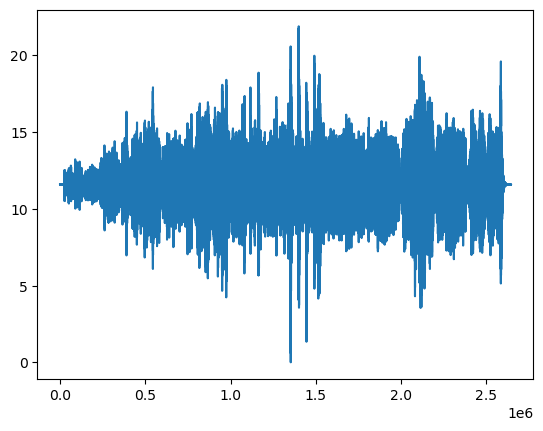

In [114]:
plt.plot(ynew)

In [116]:
ynew2 = np.round(ynew, decimals=2)

In [117]:
from IPython.display import Audio

In [118]:
Audio(data=ynew2, rate=sr)

In [119]:
vocab = sorted(set(ynew))

In [120]:
print(f'{len(vocab)} carácteres únicos')

138 carácteres únicos


Para el entrenamiento necesitamos un dataset de pares de `(entrada, etiqueta)`, donde `entrada` y `etiqueta` son secuencias. En cada paso del tiempo la entrada es el carácter actual y la etiqueta es el carácter subsiguiente.

In [121]:
all_values = tf.data.Dataset.from_tensor_slices(ynew2)

In [122]:
length_seq = 100

In [123]:
sequences = all_values.batch(length_seq+1, drop_remainder=True)

In [124]:
def divide_input_output(sequence):
    music_input = sequence[:-1]
    music_output = sequence[1:]
    return music_input, music_output

In [125]:
dataset = sequences.map(divide_input_output)

In [126]:
dataset

<_MapDataset element_spec=(TensorSpec(shape=(100,), dtype=tf.float32, name=None), TensorSpec(shape=(100,), dtype=tf.float32, name=None))>

In [127]:
# Tamaño de los lotes
BATCH = 64

# Tamaño del "buffer" para barajar los datos
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

In [128]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.float32, name=None), TensorSpec(shape=(64, 100), dtype=tf.float32, name=None))>

In [129]:
vocab_size = len(vocab)

embedding_dim = 256

rnn_units = 1024

In [134]:
class MyModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__(self)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(rnn_units, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)
        
    def call(self, inputs, states=None, return_state=False, training=False):
        x = inputs
        x = self.embedding(x, training=training)
        if states is None:
            states = self.gru.get_initial_state(x)
        x, states = self.gru(x, initial_state=states, training=training)
        x = self.dense(x, training=training)
        
        if return_state:
            return x, states
        else:
            return x

In [135]:
model = MyModel(vocab_size=vocab_size, 
                  embedding_dim=embedding_dim, 
                  rnn_units=rnn_units)

In [136]:
example_output_batch.shape

TensorShape([64, 100])

In [137]:
for example_input_batch, example_output_batch in dataset.take(1):
    example_predictions_batch = model(example_input_batch)
    print(example_predictions_batch.shape, "# (lote, secuencia, vocabulario)")

2023-11-12 22:18:03.858752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [2643264]
	 [[{{node Placeholder/_0}}]]
2023-11-12 22:18:03.859156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [2643264]
	 [[{{node Placeholder/_0}}]]


(64, 100, 138) # (lote, secuencia, vocabulario)


In [139]:
model.summary()

Model: "my_model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     multiple                  35328     
                                                                 
 gru_7 (GRU)                 multiple                  3938304   
                                                                 
 dense_7 (Dense)             multiple                  141450    
                                                                 
Total params: 4,115,082
Trainable params: 4,115,082
Non-trainable params: 0
_________________________________________________________________


In [140]:
indices_sample = tf.random.categorical(example_predictions_batch[0], num_samples=1)

In [40]:
indices_sample = tf.squeeze(indices_sample, axis=-1).numpy()

In [142]:
indices_sample

<tf.Tensor: shape=(100, 1), dtype=int64, numpy=
array([[110],
       [  1],
       [ 90],
       [ 17],
       [ 40],
       [ 93],
       [ 75],
       [  9],
       [  9],
       [ 59],
       [ 58],
       [121],
       [ 93],
       [ 21],
       [ 91],
       [  9],
       [ 19],
       [103],
       [ 31],
       [ 88],
       [122],
       [ 77],
       [ 29],
       [ 29],
       [124],
       [ 17],
       [ 56],
       [ 21],
       [ 98],
       [ 88],
       [ 65],
       [  5],
       [105],
       [ 70],
       [ 78],
       [ 75],
       [136],
       [100],
       [ 36],
       [ 97],
       [ 50],
       [125],
       [ 56],
       [ 93],
       [ 98],
       [ 82],
       [ 22],
       [ 15],
       [ 69],
       [ 87],
       [129],
       [133],
       [122],
       [ 78],
       [118],
       [ 96],
       [114],
       [ 73],
       [124],
       [ 20],
       [129],
       [ 76],
       [ 53],
       [ 56],
       [ 11],
       [ 66],
       [ 68],
       [ 38],


In [149]:
for idx in indices_sample.numpy().flatten():
    print(vocab[idx])

0.37
-0.73
0.17
-0.56
-0.33
0.2
0.02
-0.64
-0.64
-0.14
-0.15
0.48
0.2
-0.52
0.18
-0.64
-0.54
0.3
-0.42
0.15
0.49
0.04
-0.44
-0.44
0.51
-0.56
-0.17
-0.52
0.25
0.15
-0.08
-0.68
0.32
-0.03
0.05
0.02
0.65
0.27
-0.37
0.24
-0.23
0.52
-0.17
0.2
0.25
0.09
-0.51
-0.58
-0.04
0.14
0.56
0.61
0.49
0.05
0.45
0.23
0.41
0.0
0.51
-0.53
0.56
0.03
-0.2
-0.17
-0.62
-0.07
-0.05
-0.35
-0.65
-0.67
-0.34
-0.18
-0.07
-0.47
0.01
0.36
-0.3
0.43
-0.37
0.29
0.11
0.07
-0.55
-0.08
0.56
-0.23
0.48
-0.51
-0.06
-0.39
0.45
-0.44
-0.12
-0.59
-0.58
0.58
0.2
-0.11
-0.61
0.04


In [151]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [152]:
example_batch_average_loss = loss(example_input_batch, example_predictions_batch)

In [154]:
print("Average loss: ", example_batch_average_loss)

Average loss:  tf.Tensor(4.8984795, shape=(), dtype=float32)


In [155]:
tf.exp(example_batch_average_loss).numpy()

134.08574

In [163]:
model.compile(optimizer='adam', loss=loss)

In [164]:
checkpoint_dir = './training_checkpoints'

In [165]:
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

In [166]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [167]:
EPOCHS = 10

In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/10


2023-11-12 22:27:35.831199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [2643264]
	 [[{{node Placeholder/_0}}]]
2023-11-12 22:27:35.831510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [2643264]
	 [[{{node Placeholder/_0}}]]
2023-11-12 22:27:36.098031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_d

 31/408 [=>............................] - ETA: 9:55 - loss: 0.4523

### Generar texto

Podemos generar texto con el modelo usando un ciclo, con seguimiento del estado interno.

![](text_generation_sampling.png)

Cada vez que llamamos al modelo, pasamos texto y su estado interno. El modelo devuelve una predicción para el próximo carácter y su estado nuevo. Pasamos la predicción y el estado de nuevo al modelo para generar más texto.

In [55]:
class UnPaso(tf.keras.Model):
    def __init__(self, modelo, cars_de_ids, ids_de_cars, temperatura=1.0):
        super().__init__()
        self.temperatura = temperatura
        self.modelo = modelo
        self.cars_de_ids = cars_de_ids
        self.ids_de_cars = ids_de_cars
        
        # Crear una máscara para prevenir generación de "[UNK]"
        #saltar_ids = self.ids_de_cars('[UNK]').numpy()
        #mascara_escasa = tf.SparseTensor(
            # Ponemos -inf en cada indice malo
        #    values=-float('inf'),
        #    indices=saltar_ids,
            # igualar la forma al vocabulario
        #    dense_shape=[len(ids_de_cars.get_vocabulary())])
        #self.mascara_prediccion = tf.sparse.to_dense(mascara_escasa)
        
    @tf.function
    def generar_un_paso(self, entradas, estados=None):
        # Convertir strings a IDs de fichas
        entrada_cars = tf.strings.unicode_split(entradas, 'UTF-8')
        entrada_ids = self.ids_de_cars(entrada_cars).to_tensor()
        
        # Ejecutar el modelo
        # logits_predichos.shape es [lote, carácteres, logits_próximo_carácter]
        logits_predichos, estados = self.modelo(inputs=entrada_ids,
                                                states=estados,
                                                return_state=True)
        # Ocupar solamente la última predicción
        logits_predichos = logits_predichos[:, -1, :]
        logits_predichos = logits_predichos/self.temperatura
        # Aplicar la mascara de predicción para prevenir "[UNK]"
        logits_predichos = logits_predichos #+ self.mascara_prediccion
        
        # Obtener muestra de los logits de salida para generar fichas de IDs
        ids_predichas = tf.random.categorical(logits_predichos, num_samples=1)
        ids_predichas = tf.squeeze(ids_predichas, axis=-1)
        
        # Convertir de fichas de ID a carácteres
        cars_predichos = self.cars_de_ids(ids_predichas)
        
        # Retornar los carácteres y el estado del modelo
        return cars_predichos, estados

In [56]:
un_paso_modelo = UnPaso(modelo, cars_de_ids, ids_de_cars)

In [57]:
comienzo = time.time()
estados = None
proximo_car = tf.constant(['ROMEO:'])
resultado = [proximo_car]

for n in range(1000):
    proximo_car, estados = un_paso_modelo.generar_un_paso(proximo_car, estados=estados)
    resultado.append(proximo_car)
    
resultado = tf.strings.join(resultado)
final = time.time()

2023-10-26 13:55:22.873876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-26 13:55:22.874897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-26 13:55:22.875975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [58]:
print(resultado[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nTiempo de ejecución:', final - comienzo)

ROMEO:
That Roomey' but thy profit of him
And city of him, put every hand.

QUEEN MARGARET:
Who had he shall not.
Mard that the mercy should but here appear
At palm and no't:
See, all post gagerel, his country may
In the sallignhest sent to-day.
Within my spirit of a city out on his paples,
Even so in the valians. Take me
The one poor cliff may pray thee. Bod!

MERENIUS:
You have no out my lord;
So hath made jow in any tame the sun.
Alto some other in done, thy heart will tear,
Dreamnedly shall 't. He going presently rescoiled him;
And now he knows my reammission which our corvins
That I may chatte; and do good pubull
And seen to long wething hours made
A gentleman in our own sovereing stand:
Being sawns uppell'd, and so we must do
And bring the sweetest squaring he hads aponet;
And so it is right old Mariqay be you, till King Henry's right,
Have dancing should to action in deft he usurp.

KING RICHARD II:
Go, A wife in tume of Ronoraft she!
The contentios of the Duke of Plater natural

Se puede implementar el paso de entrenamiento directamente, usando `tf.GradientTape`.

In [103]:
class CustomTraining(MiModelo):
    @tf.function
    def train_step(self, inputs):
        inputs, labels = inputs
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            loss = self.loss(labels, predictions)
        grads = tape.gradient(loss, modelo.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, modelo.trainable_variables))

        return {'loss': loss}

In [104]:
modelo = CustomTraining(vocab_size=len(ids_de_cars.get_vocabulary()),
                        embedding_dim=embedding_dim,
                        rnn_units=rnn_units)

In [105]:
modelo.compile(optimizer = tf.keras.optimizers.Adam(),
               loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [106]:
modelo.fit(dataset, epochs=1)

2023-10-17 15:41:13.429748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-17 15:41:13.431293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-17 15:41:13.432282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

  6/172 [>.............................] - ETA: 7:54 - loss: 4.2275

KeyboardInterrupt: 